In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats


from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import pandas_profiling

In [5]:
data = pd.read_csv('addvert_liner_reg_git.csv')

In [6]:
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [7]:
def continuous_var_summary(x):
    return pd.Series([x.dtype, x.nunique(), x.count(), x.isnull().sum(), x.sum(), x.mean(),
                      x.median(), x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
            index = ['DataType', 'C', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [8]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(), x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C', 'N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [9]:
# for missing values
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [10]:
# for 1 hot encoding on cat variables
def create_dummies(df, colname):
    
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [11]:
report = pandas_profiling.ProfileReport(data)

In [12]:
report.to_file(output_file = 'profilereport_advert_data.html')

In [13]:
data_cont_var = data.select_dtypes(['int', 'float'])

In [14]:
data.cat_var = data.select_dtypes('object')

/Users/grofers/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [15]:
data_cont_var.apply(continuous_var_summary).transpose

<bound method DataFrame.transpose of                TV    radio newspaper    sales
DataType  float64  float64   float64  float64
C             190      167       172      121
N             200      200       200      200
NMISS           0        0         0        0
SUM       29408.5   4652.8    6110.8   2804.5
MEAN      147.042   23.264    30.554  14.0225
MEDIAN     149.75     22.9     25.75     12.9
STD       85.8542  14.8468   21.7786  5.21746
VAR       7370.95  220.428   474.308  27.2219
MIN           0.7        0       0.3      1.6
P1          5.387    0.399     0.999    4.784
P5         13.195    1.995       3.6      6.6
P10         24.88      3.4      5.99     7.96
P25        74.375    9.975     12.75   10.375
P50        149.75     22.9     25.75     12.9
P75       218.825   36.525      45.1     17.4
P90        261.44    43.52     59.07    21.71
P95       280.735    46.81    71.825     23.8
P99       292.907     49.4    89.515   25.507
MAX         296.4     49.6       114       

In [16]:
# Outlier treatment just to be safe
data_cont_var = data_cont_var.apply(lambda x: x.clip(lower = x.quantile(0.01), 
                                                         upper = x.quantile(0.99)))

In [17]:
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [18]:
data_cont_var.describe()

,TV,radio,newspaper,sales
count,200.00000,200.000000,200.000000,200.000000
mean,147.05144,23.265490,30.378640,14.035410
std,85.76786,14.841149,21.192412,5.142908
min,5.38700,0.399000,0.999000,4.784000
25%,74.37500,9.975000,12.750000,10.375000
50%,149.75000,22.900000,25.750000,12.900000
75%,218.82500,36.525000,45.100000,17.400000
max,292.90700,49.400000,89.515000,25.507000


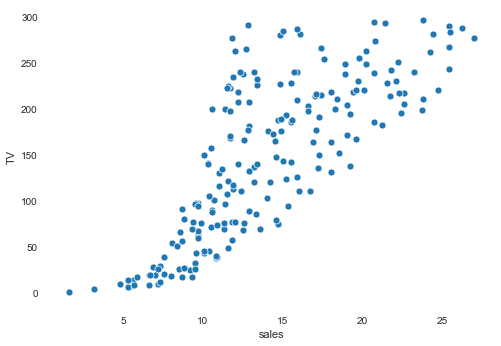

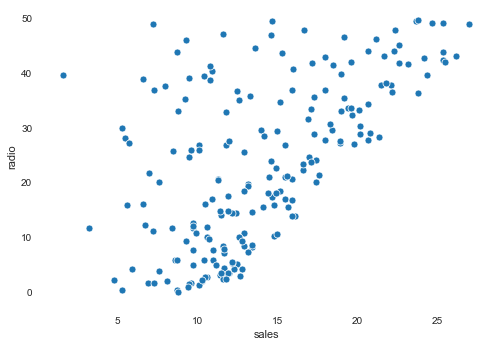

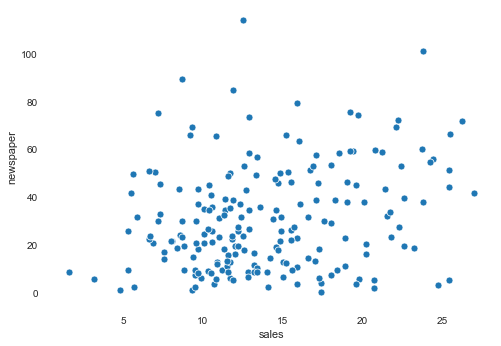

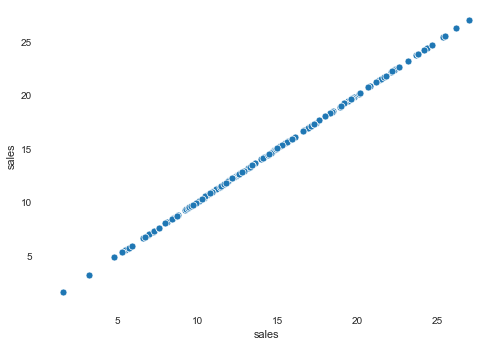

In [19]:
# plotting data
for i in data.columns:
    sns.scatterplot(data['sales'], data[i])
    plt.show()

    


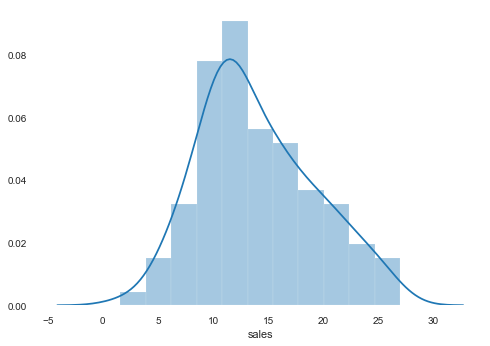

In [20]:
sns.distplot(data['sales'])
# This is almost a normal dist so we can use liner reg

In [21]:
data['sales'].skew()

0.4075714250767127

In [22]:
data.corr()['sales']
# to check corr of X variables with y (Sales)

TV           0.782224
radio        0.576223
newspaper    0.228299
sales        1.000000
Name: sales, dtype: float64

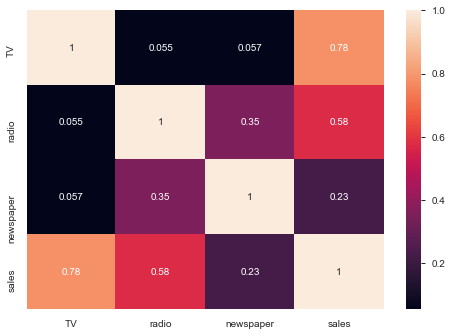

In [23]:
sns.heatmap(data.corr(), annot = True)

In [24]:
# using F-regression to select variables

In [25]:
features = data.columns.difference(['sales'])

In [26]:
features

Index(['TV', 'newspaper', 'radio'], dtype='object')

In [27]:
from sklearn.feature_selection import f_regression

In [28]:
features = data[features]
target = data['sales']
F_values, p_values  = f_regression( features, target )

In [29]:
F_Regression_results = pd.concat([pd.Series(features.columns), 
                            pd.Series(F_values), pd.Series(p_values).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [30]:
F_Regression_results
# all features have very low pvalues, so good to go (typically below 0.01)

,Feature,F_value,p_value
0,TV,312.144994,0.00000
1,newspaper,10.887299,0.00115
2,radio,98.421588,0.00000


In [31]:
# now using Mutual Information to check colinearily

In [32]:
import sklearn.feature_selection
# sklearn.feature_selection.mututal_info_classif

In [52]:
arr = pd.Series(sklearn.feature_selection.mutual_info_regression(X = features, y = data['sales'], random_state = 333).round(3))

In [53]:
arr

0    0.672
1    0.000
2    0.467
dtype: float64

In [64]:
# checking for VIF now, it is a check for multicolinearity in data , useful to check relation among x variables

In [66]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [69]:
features.columns

Index(['TV', 'newspaper', 'radio'], dtype='object')

In [70]:
parameters = 'sales ~ ' + ' + '.join(features)

In [71]:
parameters

'sales ~ TV + newspaper + radio'

In [76]:
y, X = dmatrices(parameters, data, return_type = 'dataframe')
X.shape[1]

4

In [78]:
variance_inflation_factor?

In [79]:
VIF = pd.DataFrame()
VIF['Features'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [80]:
VIF

,Features,VIF
0,Intercept,6.848900
1,TV,1.004611
2,newspaper,1.145187
3,radio,1.144952


In [81]:
# VIF = 1/1-r2
# that means if r2 is high 1-r2 is low and that meand 1/1-r2 is high
# high VIF indicates multicolinearity

# for eg if vif = 5
# then 1/1-r2 = 5
# 1-r2 = 1/5
# r2 = 4/5 or R2  = 80%

In [82]:
# /Building the model as VIF for all variables is less than 5

In [84]:
features.columns
# our X variables

Index(['TV', 'newspaper', 'radio'], dtype='object')

In [89]:
# divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related functions
train_X, test_X, train_y, test_y = train_test_split(data[features.columns], 
            data['sales'], test_size = 0.3, random_state = 12345)

In [90]:
print('No of obs in training: ', len(train_X), ' | ', 'No of obs in testing: ', len(test_X))

No of obs in training:  140  |  No of obs in testing:  60


In [91]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:
# linear reg eqn is of the form # smf.ols(' y ~ x1 + x2 + x3 + .... + xn', train )

In [94]:
feature_names = features.columns

In [95]:
feature_names

Index(['TV', 'newspaper', 'radio'], dtype='object')

In [98]:
formula_m0 = 'sales ~ ' + ' + '.join( feature_names )
formula_m0

'sales ~ TV + newspaper + radio'

In [101]:
train, test = train_test_split(data, test_size = 0.3, random_state = 333)

In [105]:
model0 =  smf.ols( formula_m0, train ).fit()

In [106]:
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     399.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.47e-67
Time:                        03:53:40   Log-Likelihood:                -272.99
No. Observations:                 140   AIC:                             554.0
Df Residuals:                     136   BIC:                             565.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8771      0.370      7.774      0.000       2.145       3.609
TV             0.0460      0.002     27.417      0.000       0.043       0.049
newspaper      0.0066      0.007      0.941      0.349      -0.007       0.020
radio          0.1810      0.011     16.864      0.000       0.160       0.202
==============================================================================
Omnibus:                       51.515   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.488
Skew:                          -1.458   Prob(JB):                     5.14e-31
Kurtosis:                       6.925   Cond. No.                         446.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
formula_m1 = 'sales ~ ' + ' + '.join( feature_names.difference(['newspaper']) )
formula_m1

'sales ~ TV + radio'

In [109]:
model1 =  smf.ols( formula_m1, train ).fit()

In [110]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     598.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.95e-68
Time:                        03:56:32   Log-Likelihood:                -273.44
No. Observations:                 140   AIC:                             552.9
Df Residuals:                     137   BIC:                             561.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9640      0.358      8.274      0.000       2.256       3.672
TV             0.0462      0.002     27.687      0.000       0.043       0.049
radio          0.1845      0.010     18.330      0.000       0.165       0.204
==============================================================================
Omnibus:                       53.365   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.877
Skew:                          -1.491   Prob(JB):                     1.05e-33
Kurtosis:                       7.141   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
# Now using model 1 to prdict sales in bot train and test data

train.loc[:, 'pred_sales'] = (model1.predict(train))
test.loc[:, 'pred_sales'] = (model1.predict(test))

In [116]:
# calculating MAE, mean absolute error
# this tells us the variation in y pred from y actual

In [118]:
MAE_train = mean_absolute_error(train.sales, train.pred_sales)

MAE_test = mean_absolute_error(test.sales, test.pred_sales)

print('MAE train is ' + str(MAE_train.round(2)))
print('MAE test is ' + str(MAE_test.round(2)))

MAE train is 1.26
MAE test is 1.24


In [119]:
# The erros are close to each other hence model is giving same error in both test and train data

In [120]:
# NOw calculating MAPE, mean abs % error
# this tells us error in prediction as a % of actual data

In [124]:
MAPE_train = np.mean(np.abs(train['sales'] - train['pred_sales'])/train['sales'])
MAPE_test = np.mean(np.abs(test['sales'] - test['pred_sales'])/test['sales'])
print('MAPE train is ' + str(MAPE_train))
print('MAPE test is ' + str(MAPE_test))


MAPE train is 0.1449406814046036
MAPE test is 0.1216135823245733


In [125]:
# These are also similar in both test and train data

In [126]:
# now calculating MSE and RMSE, RMSE is SQr root of MSE

In [127]:
MSE_train = mean_squared_error(train.sales, train.pred_sales)
MSE_test = mean_squared_error(test.sales, test.pred_sales)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  2.9109340562517536  |  MSE of testing data:  2.503392876984279
RMSE of training data:  1.7061459656933675  |  RMSE of testing data:  1.5822113882109048


In [128]:
# checking for any corr in actual and pred

In [130]:
Corr_train = stats.pearsonr(train.sales, train.pred_sales)
Corr_test = stats.pearsonr(test.sales, test.pred_sales)

In [131]:
Corr_train, Corr_test

((0.947264900910334, 4.462717240990069e-70),
 (0.9465742224265115, 3.4276465953557275e-30))

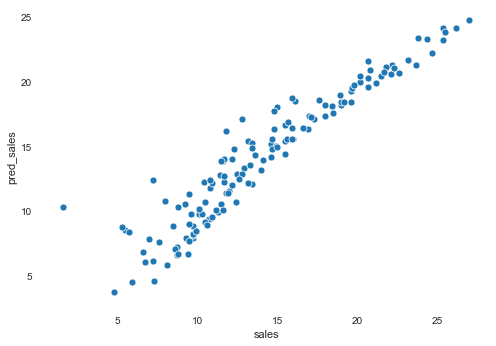

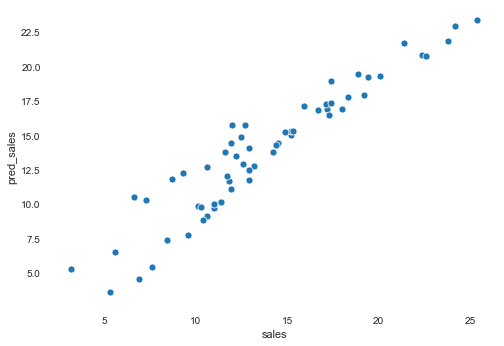

In [135]:
sns.scatterplot(train.sales, train.pred_sales)
plt.show()
sns.scatterplot(test.sales, test.pred_sales)
plt.show()


In [139]:
# Decile analysis
pd.qcut?

In [146]:
s = pd.Series([1,2,3,6,9,11,13,34,45,66])

In [149]:
print(pd.cut(s,3))
print(pd.qcut(s,3))

0     (0.935, 22.667]
1     (0.935, 22.667]
2     (0.935, 22.667]
3     (0.935, 22.667]
4     (0.935, 22.667]
5     (0.935, 22.667]
6     (0.935, 22.667]
7    (22.667, 44.333]
8      (44.333, 66.0]
9      (44.333, 66.0]
dtype: category
Categories (3, interval[float64]): [(0.935, 22.667] < (22.667, 44.333] < (44.333, 66.0]]
0    (0.999, 6.0]
1    (0.999, 6.0]
2    (0.999, 6.0]
3    (0.999, 6.0]
4     (6.0, 13.0]
5     (6.0, 13.0]
6     (6.0, 13.0]
7    (13.0, 66.0]
8    (13.0, 66.0]
9    (13.0, 66.0]
dtype: category
Categories (3, interval[float64]): [(0.999, 6.0] < (6.0, 13.0] < (13.0, 66.0]]


In [151]:
train['Deciles'] = pd.qcut( train['pred_sales'], 10, labels = False )
test['Deciles'] = pd.qcut( test['pred_sales'], 10, labels = False )

/Users/grofers/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/grofers/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [169]:
td_D = train.groupby('Deciles')['sales', 'pred_sales'].mean().reset_index()
ts_D = test.groupby('Deciles')['sales', 'pred_sales'].mean().reset_index()

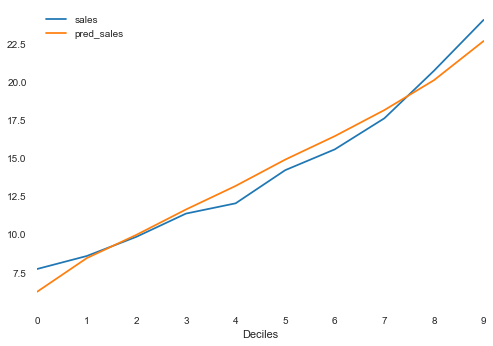

In [170]:
td_D.plot(kind = 'line', x = 'Deciles')

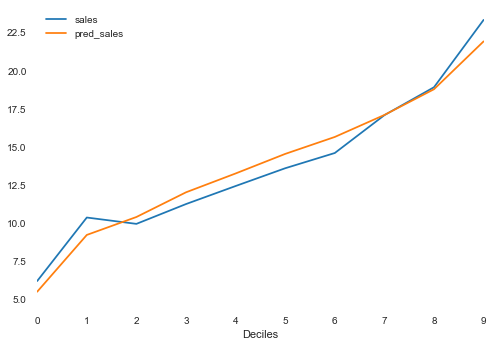

In [172]:
ts_D.plot(kind = 'line', x = 'Deciles')

In [173]:
# checking distribution of errors (y-ypred)

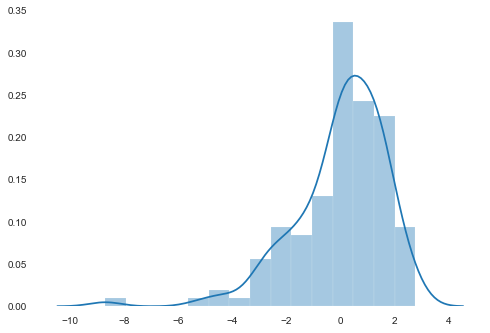

In [175]:
sns.distplot(model1.resid)
plt.show()

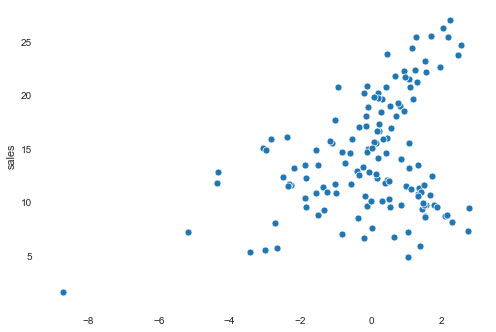

In [178]:
sns.scatterplot(model1.resid, train.sales)

In [179]:
# the scatter plot b/n y and errors should be random and not followinhg any particular pattern